# Predicting Insurance Cross Sell Opportunities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Importing the dataset

In [2]:
insurance_df = pd.read_csv('data/insurance_cross_sell.csv', index_col='id')
insurance_df.head() 

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
insurance_df.count()

Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

From dataset importing, we can observe that the dataset does not have any missing values. The dataset has 11 features and 381109 observations. The dataset has 8 categorical features and 3 numerical features which are  "Age", "Annual_Premium", "Vintage". 
The target variable is 'Response' which is a binary variable. <br>
Let's compute some statistics of the numerical features.

In [4]:
insurance_df[["Age", "Annual_Premium", "Vintage"]].describe().round(2)


,Age,Annual_Premium,Vintage
count,381109.00,381109.00,381109.00
mean,38.82,30564.39,154.35
std,15.51,17213.16,83.67
min,20.00,2630.00,10.00
25%,25.00,24405.00,82.00
50%,36.00,31669.00,154.00
75%,49.00,39400.00,227.00
max,85.00,540165.00,299.00


In [5]:
df = insurance_df.copy()

## Exploratory Data Analysis
### Numerical Features

In [6]:
from scipy.stats import chi2_contingency
def chi_squared_test(data, feature1, feature2):
    crosstab = pd.crosstab(data[feature1], data[feature2])
    chi2, p, _, _ = chi2_contingency(crosstab)
    print(f"Chi2: {chi2:.2f}, p-value: {p:.2f}")
    if(p < 0.05):
        print(f"Features {feature1} and {feature2} are dependent")
    else:
        print(f"Features {feature1} and {feature2} are independent")

In [7]:
df_numerical = df[["Age", "Annual_Premium", "Vintage"]]

Chi2: 21194.66, p-value: 0.00
Features Age and Response are dependent


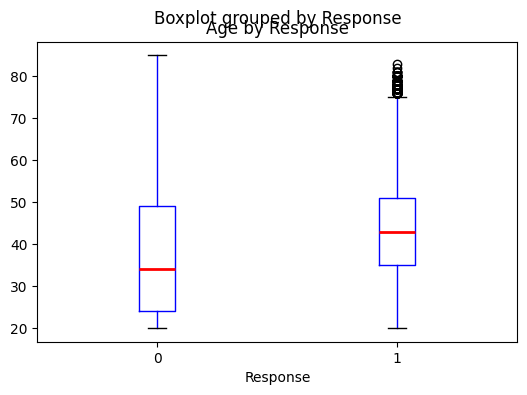

In [8]:
boxplt = df.boxplot(column='Age', by='Response', figsize=(6, 4), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) )
plt.title('Age by Response')
chi_squared_test(df, "Age", "Response")


Chi2: 260.32, p-value: 0.89
Features Vintage and Response are independent


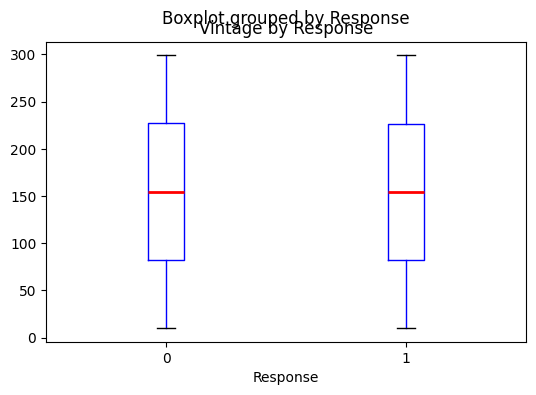

In [9]:
boxplt = df.boxplot(column='Vintage', by='Response', figsize=(6,4), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) ) # medianprops=dict(color="red", linewidth=2), 
plt.title('Vintage by Response')
chi_squared_test(df, "Vintage", "Response")


Chi2: 52395.57, p-value: 0.00
Features Annual_Premium and Response are dependent


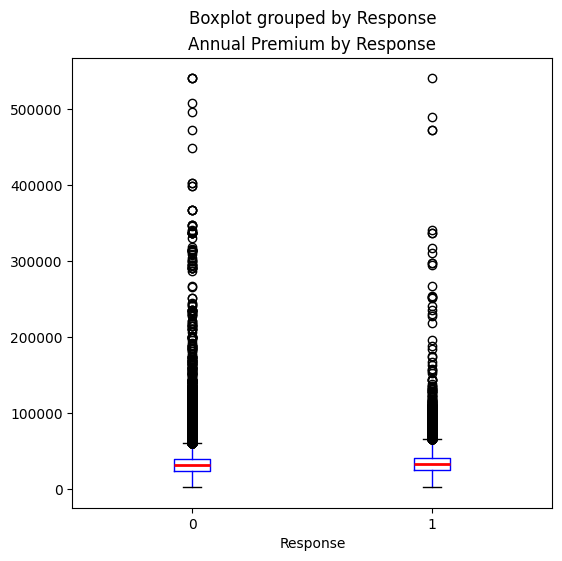

In [10]:
boxplt = df.boxplot(column='Annual_Premium', by='Response', figsize=(6,6), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2))
plt.title('Annual Premium by Response')
chi_squared_test(df, "Annual_Premium", "Response")


### Catetorical Features

In [11]:
df_categorical = insurance_df.drop(["Annual_Premium", "Age", "Vintage", "Response"],  axis=1).copy()
for column in df_categorical.columns:
    print(df_categorical[column].value_counts())

Gender
Male      206089
Female    175020
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64
Previously_Insured
0    206481
1  

As we cab observe, the dataset is imbalanced as the number of observations for 'Response' = 1 is 46710 and for 'Response' = 0 is 334399, and other categorical features are also imbalanced (for example, 'Vehicle_Age' has 164786 observations for '< 1 Year' and 200316 observations for '> 2 Years'). This is an important factor to consider while building the model.<br>
It is interesting to observe that the dataset has 2 features 'Policy_Sales_Channel' and 'Region_Code' which have 155 and 53 unique values respectively. This is a large number of unique values for categorical features and would be another challenging point while building the model.<br>
There are 812 buyers who have not a driving license, and just 41 of them are interested in the vehicle insurance. This is a very small number of observations.

In [12]:
responce_with_no_licence = insurance_df[insurance_df["Driving_License"] == 0]["Response"]
print(responce_with_no_licence.value_counts())
#potrebbe trattarsi di una bicicletta o di un monopattino elettrico ad esempio


Response
0    771
1     41
Name: count, dtype: int64


In [13]:
def show_precentage(plot, crosstab):
     for p in plot.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height/crosstab.sum(axis=1) * 100
        if percentage.iloc[0] > 1.5:
                plot.text(x + width/2, y + height/2, f"{percentage.iloc[0]:.2f}%",
                        horizontalalignment='center', verticalalignment='center',
                        color='black')
    

Chi2: 1047.71, p-value: 0.00
Features Gender and Response are dependent


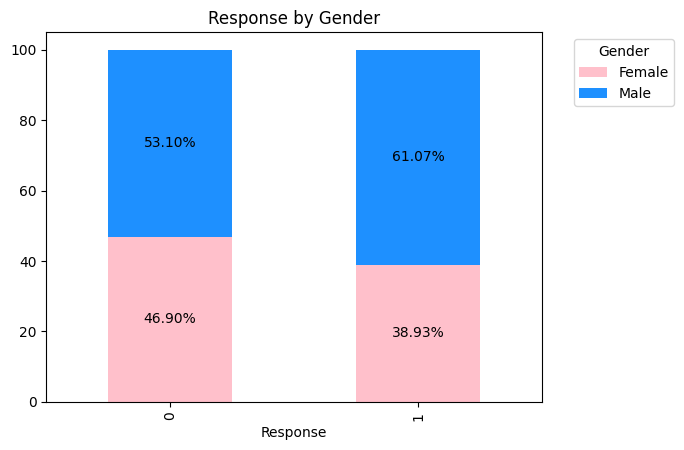

----------------------------------------------------------------------
Chi2: 38.63, p-value: 0.00
Features Driving_License and Response are dependent


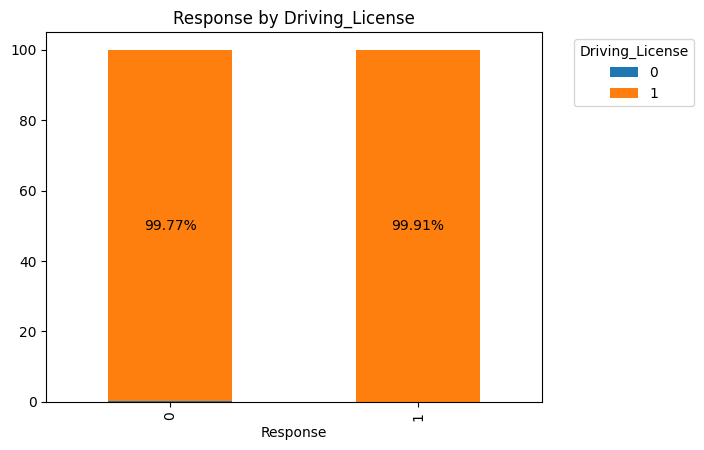

----------------------------------------------------------------------
Chi2: 7267.84, p-value: 0.00
Features Region_Code and Response are dependent


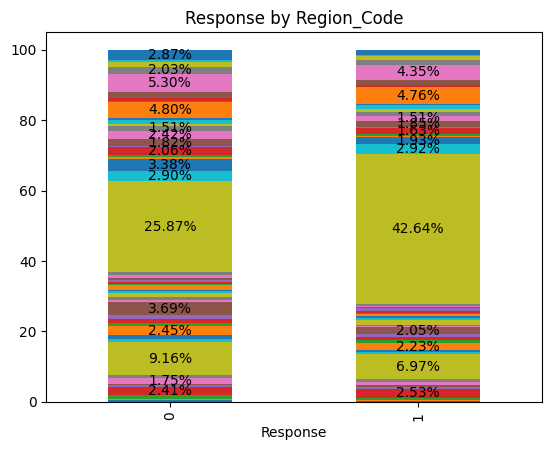

----------------------------------------------------------------------
Chi2: 44357.96, p-value: 0.00
Features Previously_Insured and Response are dependent


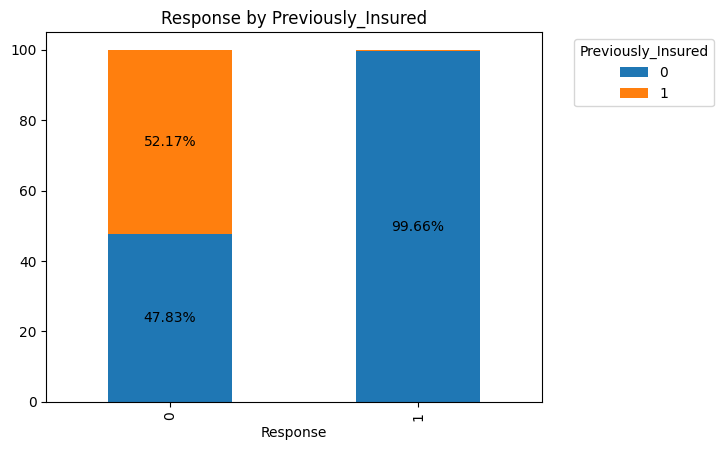

----------------------------------------------------------------------
Chi2: 18771.89, p-value: 0.00
Features Vehicle_Age and Response are dependent


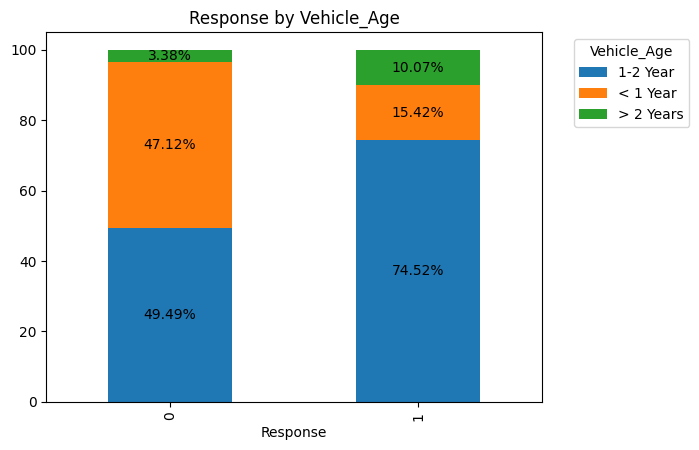

----------------------------------------------------------------------
Chi2: 47864.76, p-value: 0.00
Features Vehicle_Damage and Response are dependent


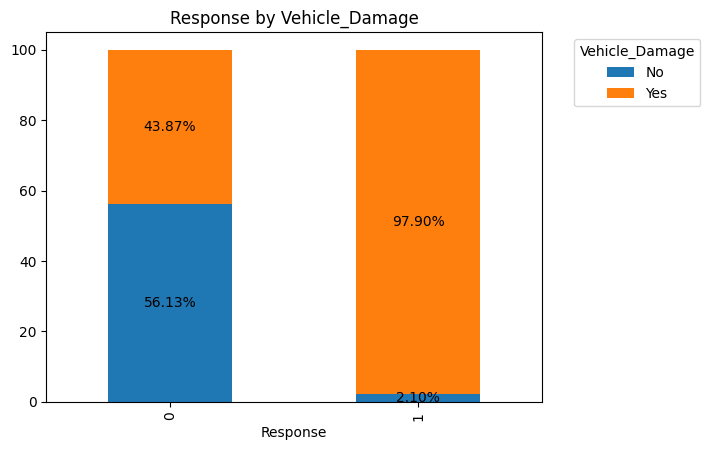

----------------------------------------------------------------------
Chi2: 26447.03, p-value: 0.00
Features Policy_Sales_Channel and Response are dependent


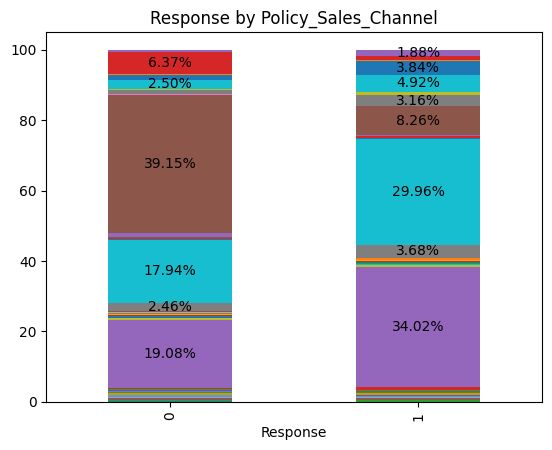

----------------------------------------------------------------------


In [14]:
for column in df_categorical.columns:
    chi_squared_test(df, column, "Response")
    crosstab = pd.crosstab(df["Response"], df_categorical[column])

    crosstab = crosstab.div(crosstab.sum(axis=1), axis=0)*100
    if(column != "Gender"):
        cross_plot = crosstab.plot(kind="bar", stacked=True, grid=False)
    else:
        cross_plot = crosstab.plot(kind="bar", stacked=True, color = ["pink", "dodgerblue"], grid=False)    
    plt.title(f"Response by {column}")
    if column == "Policy_Sales_Channel" or column == "Region_Code":
        plt.legend().remove()
    else:
        plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    show_precentage(cross_plot, crosstab)
    plt.show()
    print("----------------------------------------------------------------------")
    

# Data Preprocessing

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encode_set(dataset, X=np.array([]), label_encoder=None, one_hot_encoder=None):
    for column in dataset.columns:
        if label_encoder is not None:
            label_encoder = LabelEncoder()
            X_tmp = label_encoder.fit_transform(dataset[column])
            X_tmp = X_tmp.reshape(X_tmp.shape[0],1)
        else:
            X_tmp = dataset[column].values.reshape(dataset[column].shape[0],1)
        if(one_hot_encoder is not None):
            X_tmp = one_hot_encoder.fit_transform(X_tmp[:,0].reshape(-1,1)).toarray()
        if X.shape[0] == 0:
            X = X_tmp
        else:
            X = np.hstack((X_tmp, X))
        print(f"Categorical feature: {column}, Number of categories: {X_tmp[1,:].shape[0]}")
    return X


In [16]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder() 

In [17]:
for column in df_categorical.columns:
    df_categorical[column] = label_encoder.fit_transform(df_categorical[column])


In [18]:
df = pd.concat([df_numerical, df_categorical, insurance_df["Response"]], axis=1)

<Axes: >

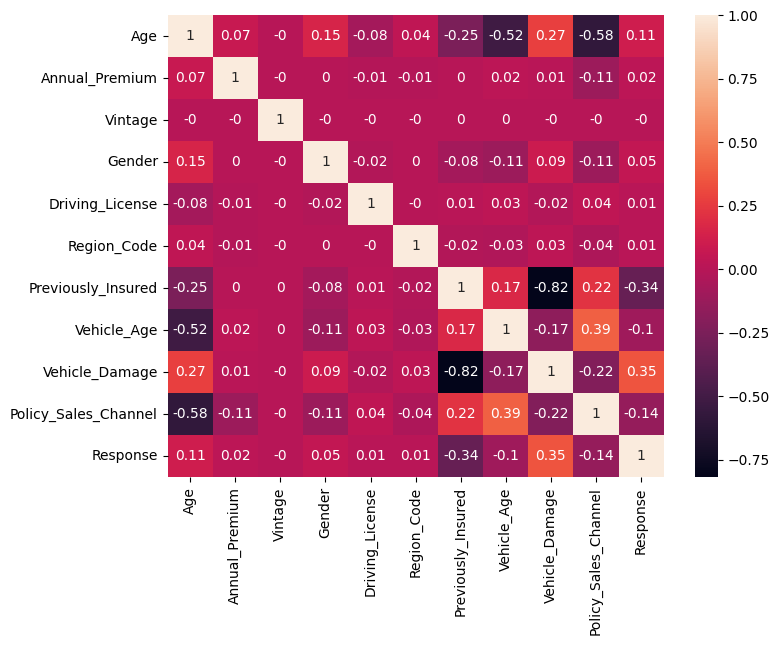

In [19]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [20]:
#df["Age"].value_counts().where(lambda x : x < 4000).dropna()
#tmp_df = pd.DataFrame(df["Age"])
#
#tmp_df.loc[tmp_df['Age']<=25, 'Age_Class'] = '1'
#tmp_df.loc[tmp_df['Age'].between(25,34), 'Age_Class'] = '2'
#tmp_df.loc[tmp_df['Age'].between(35,44), 'Age_Class'] = '3'
#tmp_df.loc[tmp_df['Age'].between(45,54), 'Age_Class'] = '4'
#tmp_df.loc[tmp_df['Age']>=55, 'Age_Class'] = '5'
#
#tmp_df = tmp_df.drop(["Age"], axis=1)
#df = pd.concat([tmp_df, df], axis=1)
#df = df.drop(["Age"], axis=1)
#df.head()

In [21]:
#df["Age_Class"].value_counts()

<Axes: >

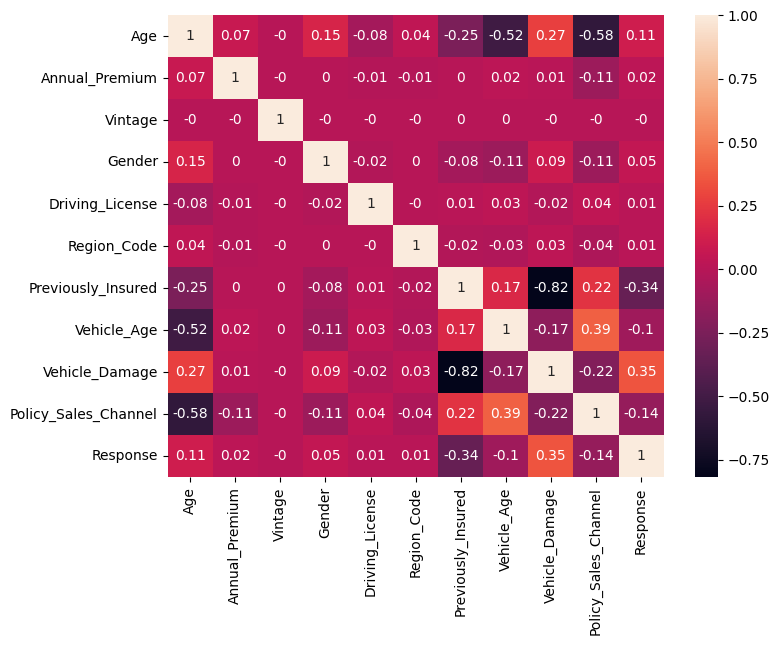

In [22]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [23]:
df = df.drop(["Vintage"], axis=1)

<Axes: >

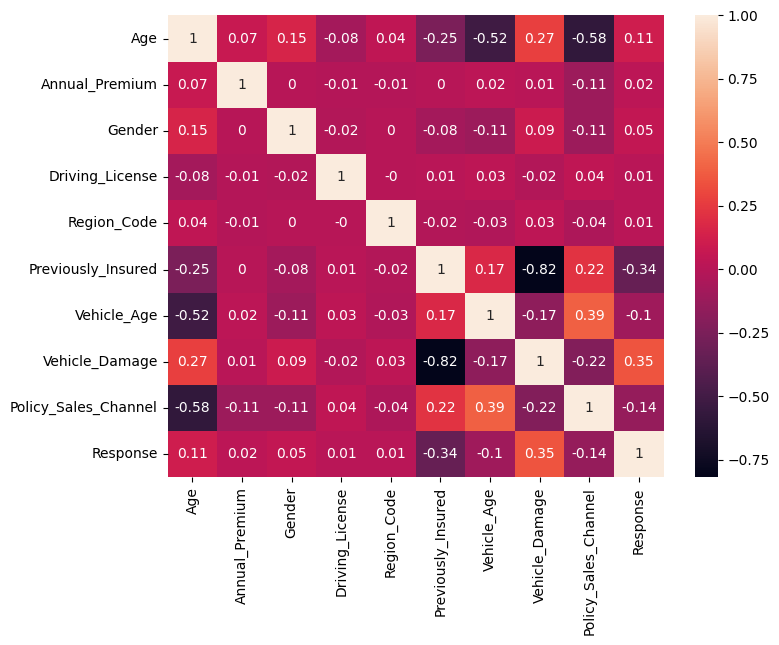

In [24]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

Policy_Sales_Channel10%
 145.0    134784
 24.0      79700
 119.0     73995
-1.0       33698
 153.0     21779
 149.0     10661
 117.0      9930
 150.0      6684
 147.0      5993
 144.0      3885
Name: count, dtype: int64


<Axes: >

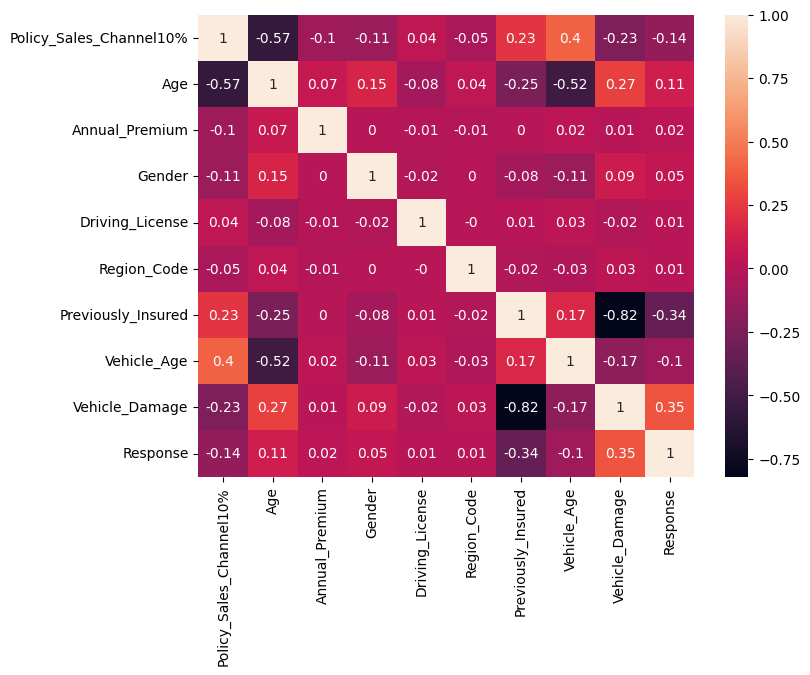

In [25]:
#df["Policy_Sales_Channel"].value_counts().where(lambda x : x > 500).dropna()
channel_counts = df["Policy_Sales_Channel"].value_counts()
threshold = round(df.shape[0] * 0.01)
valid_channels = channel_counts[channel_counts >= threshold].index

tmp_df = pd.DataFrame(df["Policy_Sales_Channel"]).copy()

tmp_df.loc[~tmp_df["Policy_Sales_Channel"].isin(valid_channels), "Policy_Sales_Channel10%"] = -1
tmp_df.loc[tmp_df["Policy_Sales_Channel"].isin(valid_channels), "Policy_Sales_Channel10%"] = tmp_df["Policy_Sales_Channel"]


print(tmp_df["Policy_Sales_Channel10%"].value_counts())

df = pd.concat([tmp_df, df], axis=1)
df = df.drop(["Policy_Sales_Channel"], axis=1)

plt.figure(figsize=(8,6))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

Region_Code10%
-1.0     155998
 28.0    106415
 8.0      33877
 46.0     19749
 41.0     18263
 15.0     13308
 30.0     12191
 29.0     11065
 50.0     10243
Name: count, dtype: int64


<Axes: >

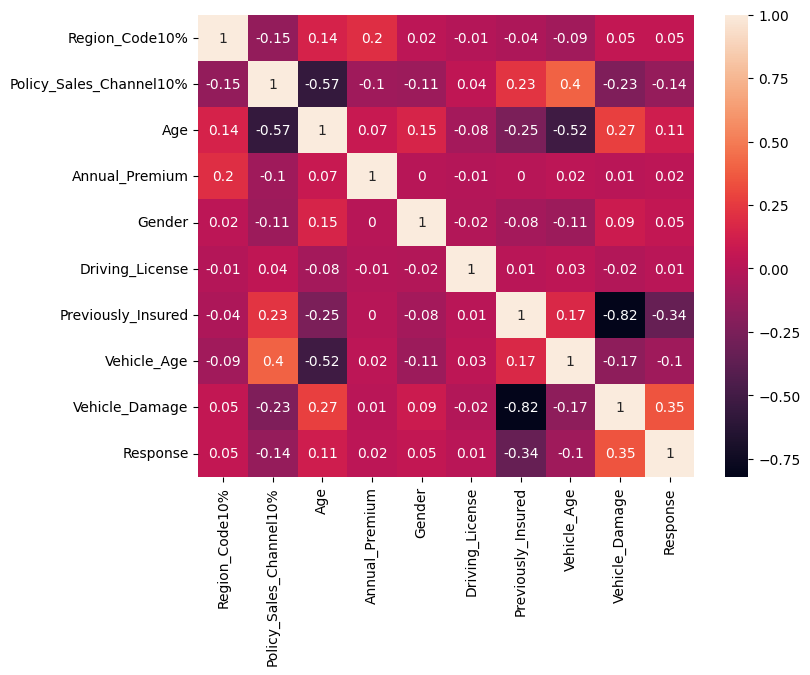

In [26]:
channel_counts = df["Region_Code"].value_counts()
threshold = round(df.shape[0] * 0.025)
valid_channels = channel_counts[channel_counts >= threshold].index

tmp_df = pd.DataFrame(df["Region_Code"]).copy()

tmp_df.loc[~tmp_df["Region_Code"].isin(valid_channels), "Region_Code10%"] = -1
tmp_df.loc[tmp_df["Region_Code"].isin(valid_channels), "Region_Code10%"] = tmp_df["Region_Code"]


print(tmp_df["Region_Code10%"].value_counts())

df = pd.concat([tmp_df, df], axis=1)
df = df.drop(["Region_Code"], axis=1)

plt.figure(figsize=(8,6))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [27]:
RANDOM_SEED = 10

df_to_handle = df.copy() #.drop(["Driving_License", "Region_Code"],axis=1).copy()

df_to_handle = df.drop(["Vehicle_Damage"],axis=1).copy()


idx = df_to_handle[df_to_handle['Response'] == 0].index
np.random.seed(RANDOM_SEED)
idx_to_remove = np.random.choice(idx, int(len(idx)*0.6), replace=False)

df_to_handle = df_to_handle.drop(idx_to_remove)
print(df_to_handle.shape)
print(df_to_handle['Response'].value_counts())

df_to_handle.index = range(len(df_to_handle))

idx = df_to_handle[df_to_handle['Response'] == 1].index
np.random.seed(RANDOM_SEED)
idx_to_add = np.random.choice(idx, int(len(idx)*0.5), replace=False)

samples_to_add = df_to_handle.iloc[idx_to_add.tolist()]
print(len(idx_to_add))
print(samples_to_add.shape)

df_to_handle = pd.concat([df_to_handle, samples_to_add], ignore_index=True)


print(df_to_handle['Response'].value_counts())





#let's see what the fraction of ones in the entire dataset is
#print("Fraction of ones in the train set: ", round(float(sum(Y_training))/float(m_training), 3))
#print("Fraction of ones in the test set: ", round(float(sum(Y_test))/float(m_test), 3))
#print("Fraction of ones in the entire dataset: ", round(float(sum(Y_training)+sum(Y_test))/float(m_training+m_test), 3))

(180470, 9)
Response
0    133760
1     46710
Name: count, dtype: int64
23355
(23355, 9)
Response
0    133760
1     70065
Name: count, dtype: int64


In [28]:


#df_annual_premium = df[["Annual_Premium"]].copy()
#df_annual_premium.loc[df["Annual_Premium"].value_counts().where(lambda x : x < 200).dropna(), 'Annual_Premium_Class'] = 'pr1'
#df_annual_premium.loc[df["Annual_Premium"].value_counts().where(lambda x : x > 200).dropna(), 'Annual_Premium_Class'] = 'pr2'

print(df["Annual_Premium"].where(df["Response"] == 0).dropna().shape)
print(df["Annual_Premium"].where(df["Response"] == 1).dropna().shape)

#df = df[df["Annual_Premium"]<=75000]
df.head()


(334399,)
(46710,)


,Region_Code10%,Policy_Sales_Channel10%,Age,Annual_Premium,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Response
id,,,,,,,,,,
1,28.0,24.0,44,40454.0,1,1,0,2,1,1
2,-1.0,24.0,76,33536.0,1,1,0,0,0,0
3,28.0,24.0,47,38294.0,1,1,0,2,1,1
4,-1.0,145.0,21,28619.0,1,1,1,1,0,0
5,41.0,145.0,29,27496.0,0,1,1,1,0,0


## Model 1: LogisticRegression with L1

In [29]:
from sklearn.metrics import log_loss, classification_report
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, RocCurveDisplay, classification_report

def evaluate_model(model, data, scaler=None, train_test_dataset='Train', print_report=False, threshold=0.5):
    '''
    Evaluate model performance on a given dataset. To be used after training the model.
    :param model: trained model
    :param data: tuple of features and labels
    :param scaler: scaler used to scale the features
    :param train_test_dataset: string to identify the dataset
    :param print_report: boolean to print classification report 
    '''
    X_, y_ = data
    if scaler is not None:
        X_ = scaler.transform(X_)

    y_pred_ = model.predict(X_)
    y_pred_proba_ = model.predict_proba(X_)

    if threshold != 0.5:
        y_pred_ = np.where(y_pred_proba_[:,1] > threshold, 1, 0)


    print('Accuracy: {:.3f}'.format(model.score(X_, y_)))
    print(f"Log-Loss: {log_loss(y_, y_pred_proba_):.3f}")
    if print_report:
        print(f"{train_test_dataset} Report:")
        print(classification_report(y_, y_pred_))


def random_split_train_test_set(X, Y, test_size=0.20, random_state=42):
    m = X.shape[0]
    m_train = int(m * (1-test_size))
    m_test = m - m_train

    
    random_indices = np.random.permutation(m)
    X_rand = X[random_indices]
    Y_rand = Y[random_indices]

    X_training, X_test, Y_training, Y_test = train_test_split(X_rand, Y_rand, test_size =float(m_test)/float(m), random_state=random_state)
    return X_training, X_test, Y_training, Y_test

def plot_confusion_matrix(confusion_matrix, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(data=confusion_matrix, annot=True, fmt='g')
    plt.title(title)
    ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
    ax.yaxis.set_ticklabels(['No', 'Yes'])
    plt.show()

## Model 2: LogisticRegression with Cross Validation and polynomial features

In [30]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures


In [31]:
def logistic_regression_CV(X_training, Y_training, cv=10, penalty='l2', solver="lbfgs" ,class_weight='balanced'):
    log_reg_cv = LogisticRegressionCV(Cs=10, cv=cv, penalty=penalty, class_weight=class_weight, solver=solver)
    log_reg_cv.fit(X_training, Y_training)

    print("Values of parameter C tried in {}-fold Cross-Validation: {}".format(cv, log_reg_cv.Cs_ ))
    CV_accuracies = np.divide(np.sum(log_reg_cv.scores_[1],0),10)
    print("Accuracies obtained for the different values of C with {}-fold Cross-Validation: {}".format(cv, CV_accuracies ))

    print("Best value C according to {}-fold Cross-Validation: {}".format(cv, log_reg_cv.C_[0] ))

    regL2_best_CV_accuracy = np.max(log_reg_cv.scores_[1])
    print("{}-fold Cross-Validation accuracies obtained with the best value of parameter C: {}".format(cv, regL2_best_CV_accuracy))

    regL2_full = LogisticRegression(C = log_reg_cv.C_[0], penalty=penalty, class_weight=class_weight, solver=solver)


    #fit the model using the best C on the entire training set
    regL2_full.fit(X_training, Y_training)


    evaluate_model(regL2_full, (X_training, Y_training), print_report=True)
    return regL2_full


In [32]:
df_to_handle["Policy_Sales_Channel10%"] = one_hot_encoder.fit_transform(df_to_handle["Policy_Sales_Channel10%"].values.reshape(-1,1)).toarray()
df_to_handle["Region_Code10%"] = one_hot_encoder.fit_transform(df_to_handle["Region_Code10%"].values.reshape(-1,1)).toarray()

std_scaler = StandardScaler()

df_to_handle["Annual_Premium"] = std_scaler.fit_transform(df_to_handle["Annual_Premium"].values.reshape(-1,1))
df_to_handle["Age"] = std_scaler.fit_transform(df_to_handle["Age"].values.reshape(-1,1))


X = df_to_handle.drop("Response", axis=1).copy()
Y = df_to_handle["Response"].copy()

#X = encode_set(X, one_hot_encoder=one_hot_encoder)


X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED)

m_training = X_training.shape[0]
m_test = X_test.shape[0]



In [33]:
poly = PolynomialFeatures(degree=2)
X_training = poly.fit_transform(X_training)
print(X_training.shape)
print(X_training)

X_test = poly.transform(X_test)
print(X_test.shape)
print(X_test)

(142677, 45)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]]
(61148, 45)
[[1. 1. 0. ... 0. 0. 4.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [34]:
log_reg = LogisticRegression(penalty='l2', C=0.01, solver="newton-cg", class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True, threshold=0.3)

Accuracy: 0.734
Log-Loss: 0.469
Train Report:
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     93486
           1       0.57      0.92      0.70     49191

    accuracy                           0.73    142677
   macro avg       0.75      0.78      0.73    142677
weighted avg       0.81      0.73      0.74    142677



In [36]:
evaluate_model(log_reg, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.3)

Accuracy: 0.730
Log-Loss: 0.473
Test Report:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     40274
           1       0.52      0.99      0.68     20874

    accuracy                           0.69     61148
   macro avg       0.76      0.76      0.69     61148
weighted avg       0.83      0.69      0.69     61148



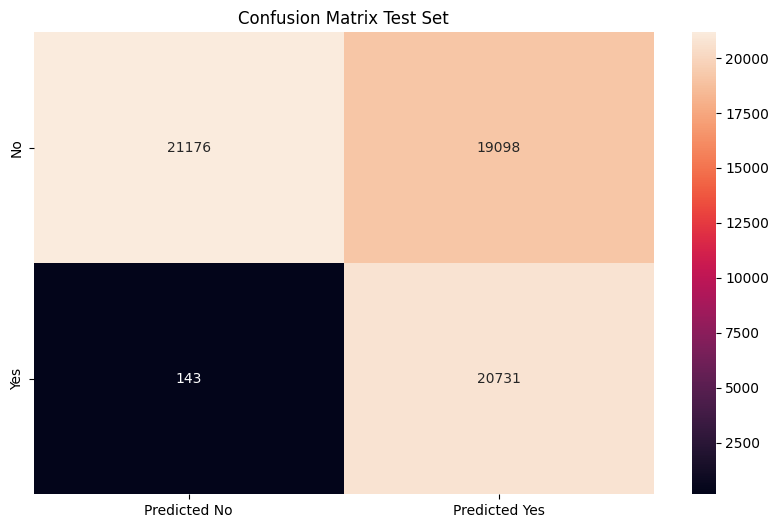

In [39]:
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.3, 1, 0)

confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

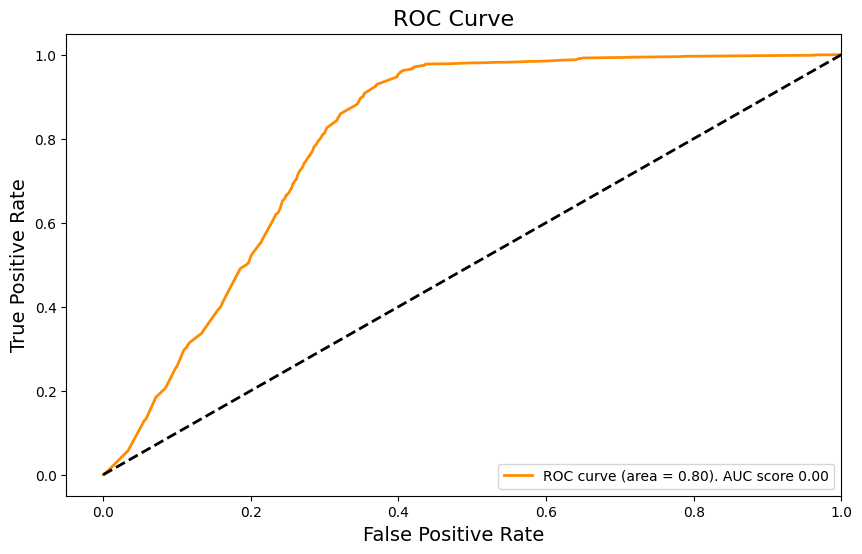

In [326]:
#plot roc curve
def plot_roc_curve(Y_test, y_pred_proba_test, multiclass=None,average=None):

    fpr, tpr, _ = roc_curve(Y_test, y_pred_proba_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_score = 0
    if multiclass is not None and average is not None:
        auc_score = roc_auc_score(Y_test, y_pred_proba_test[:,1], multi_class=multiclass, average=average)
    plt.figure(figsize=(10, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f). AUC score %0.2f' % (roc_auc, auc_score))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, y_pred_proba_test)

Values of parameter C tried in 5-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 5-fold Cross-Validation: [0.32511833 0.32511833 0.32511833 0.32511833 0.32511833 0.32511833
 0.32511833 0.32511833 0.32511833 0.32511833]
Best value C according to 5-fold Cross-Validation: 0.0001
5-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.6528961140747858
Accuracy: 0.650
Log-Loss: 0.591
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.57      0.72    157175
           1       0.37      0.98      0.53     40593

    accuracy                           0.65    197768
   macro avg       0.68      0.77      0.63    197768
weighted avg       0.86      0.65      0.68    197768

Accuracy: 0.650
Log-Loss: 0.591
Train Report:
              precisi

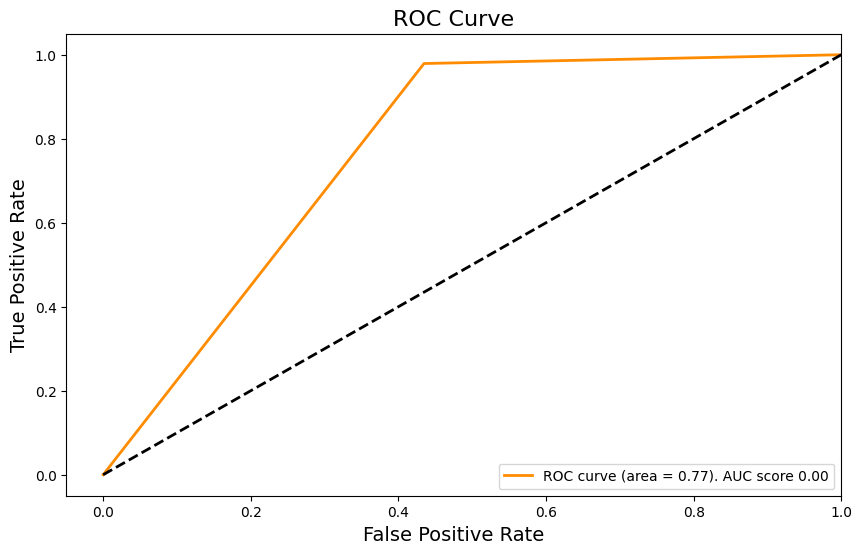

In [327]:

for i in range (1, 2):
    poly = PolynomialFeatures(i)
    X_training_poly = poly.fit_transform(X_training)
    regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')
    evaluate_model(regL2_full, (X_training_poly, Y_training), train_test_dataset='Train', print_report=True, threshold=0.6)
    y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
    plot_roc_curve(Y_training, y_pred_proba_training)
#poly = PolynomialFeatures(2)
#X_training_poly = poly.fit_transform(X_training)
#regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')

In [328]:
X_test_poly = poly.fit_transform(X_test)
evaluate_model(regL2_full, (X_test_poly, Y_test), train_test_dataset='Test', print_report=True, threshold=0.6)


Accuracy: 0.648
Log-Loss: 0.593
Test Report:


              precision    recall  f1-score   support

           0       0.99      0.56      0.72     67395
           1       0.37      0.98      0.53     17364

    accuracy                           0.65     84759
   macro avg       0.68      0.77      0.63     84759
weighted avg       0.86      0.65      0.68     84759



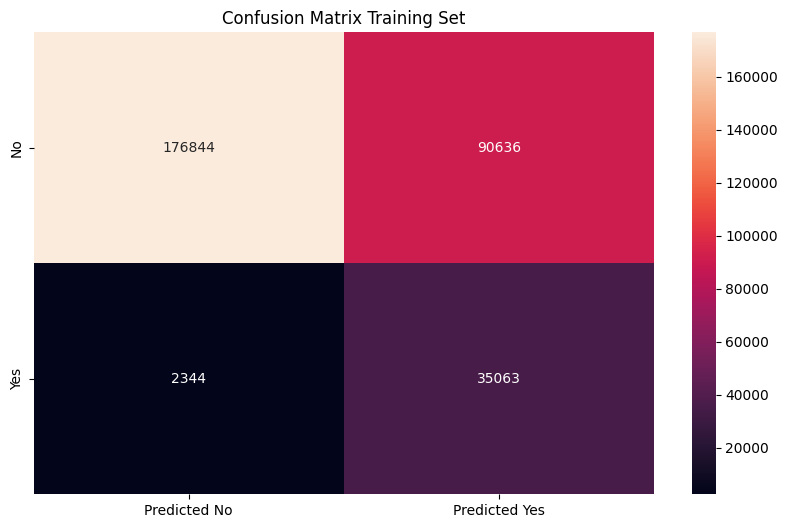

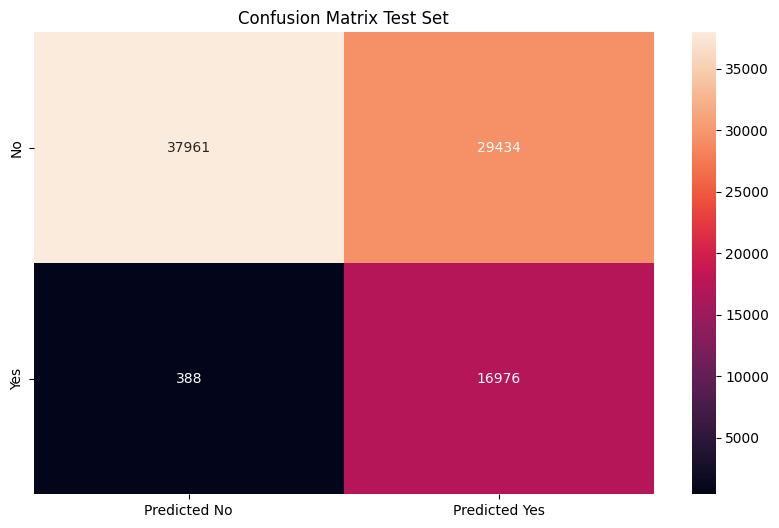

In [329]:
y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
y_pred_training = np.where(y_pred_proba_training[:,1] > 0.6, 1, 0)
confusion_matrix_training = confusion_matrix(Y_training, y_pred_training)

y_pred_proba_test = regL2_full.predict_proba(X_test_poly)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.6, 1, 0)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)


plot_confusion_matrix(confusion_matrix_train, "Confusion Matrix Training Set")
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

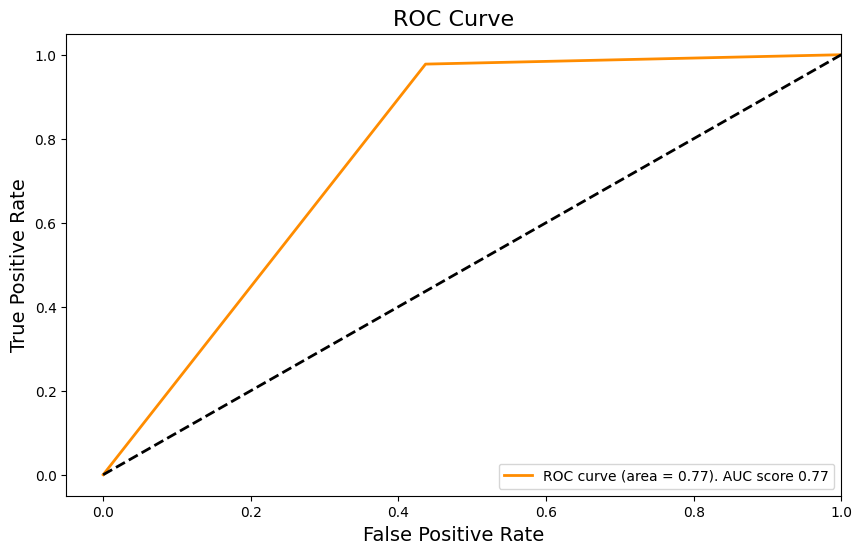

In [330]:
plot_roc_curve(Y_test, y_pred_proba_test, multiclass='ovo', average='macro')
